In [2]:
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\carlv\AppData\Local\Temp\ipykernel_5424\1505719282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
path = 'pics/DVPP2'
services = ['FCR', 'FFR', 'FFR_FCR']
# df = pd.read_csv('data/energy_provision.csv', index_col=0)
service = services[0]

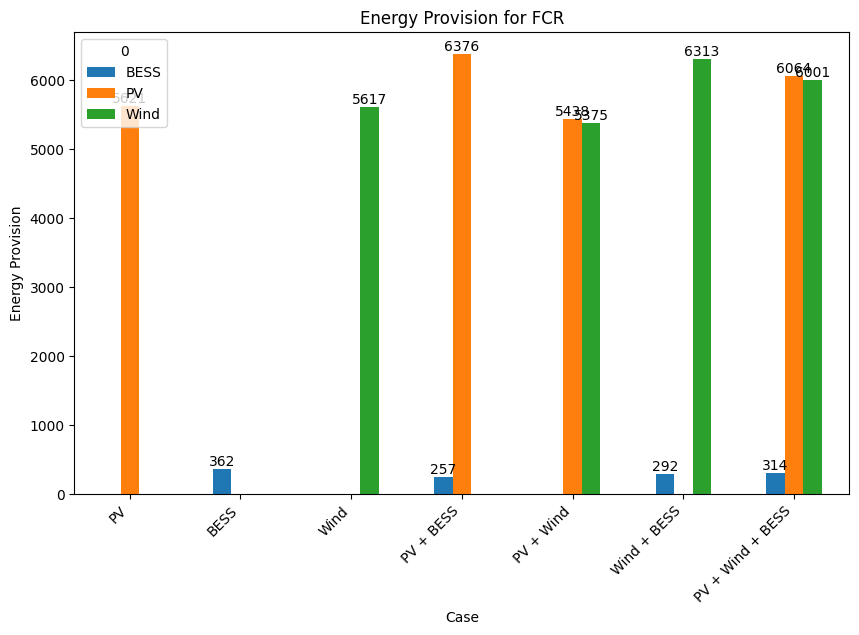

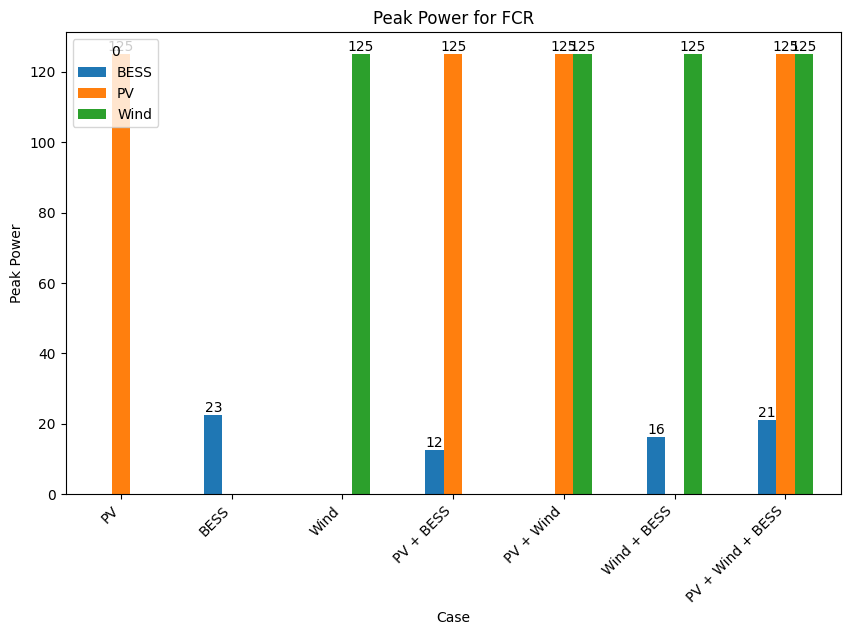

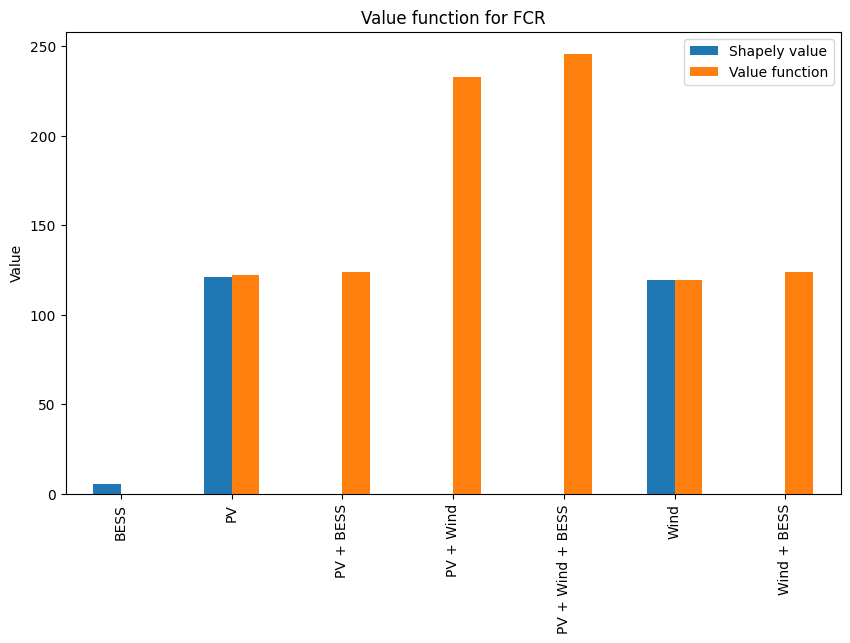

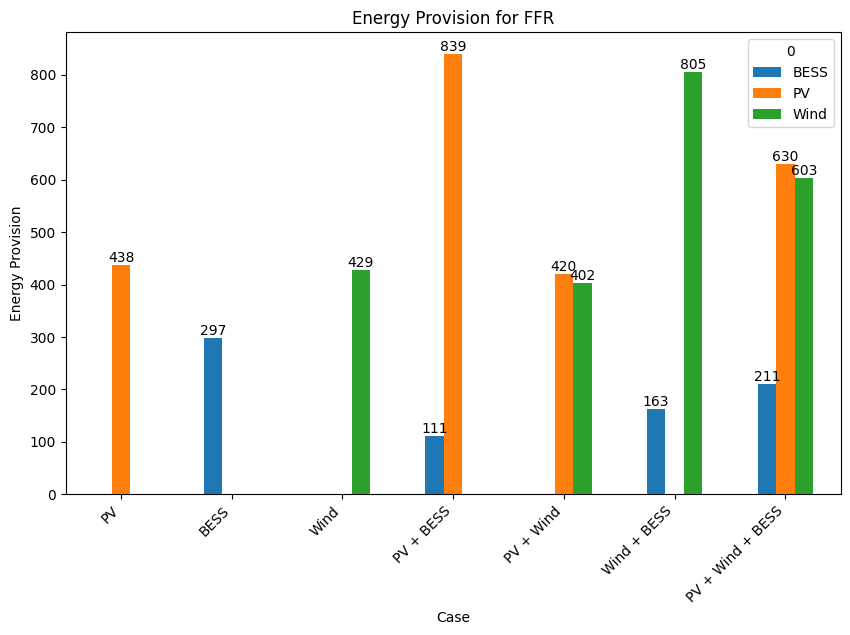

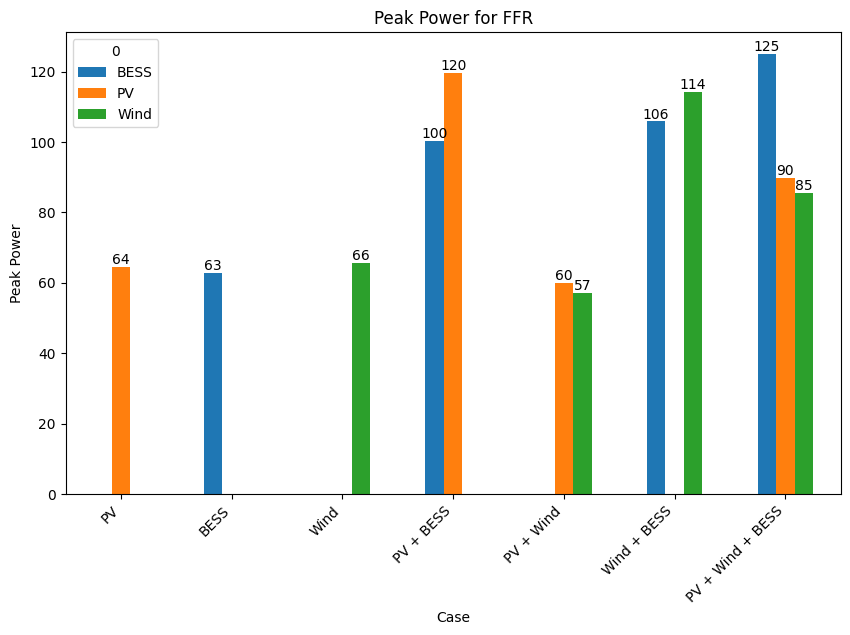

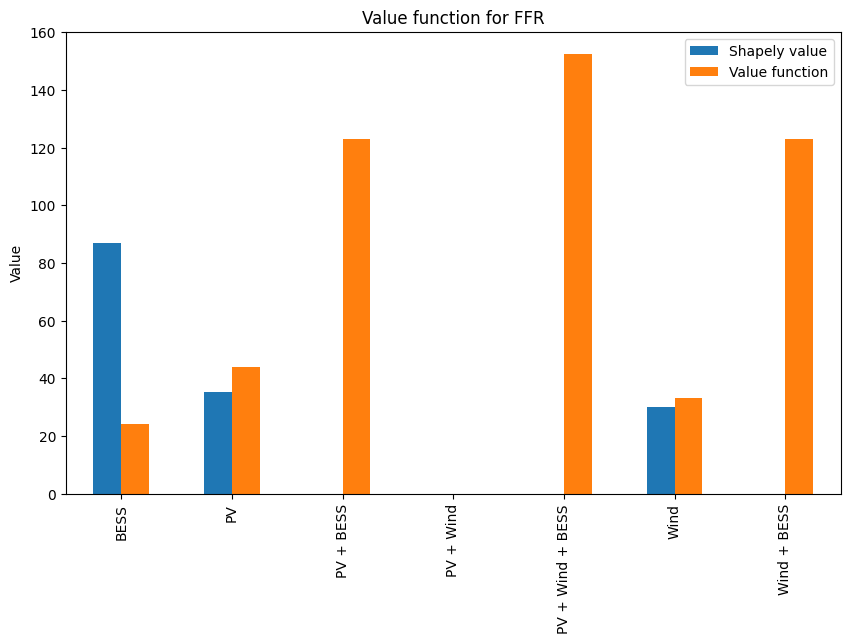

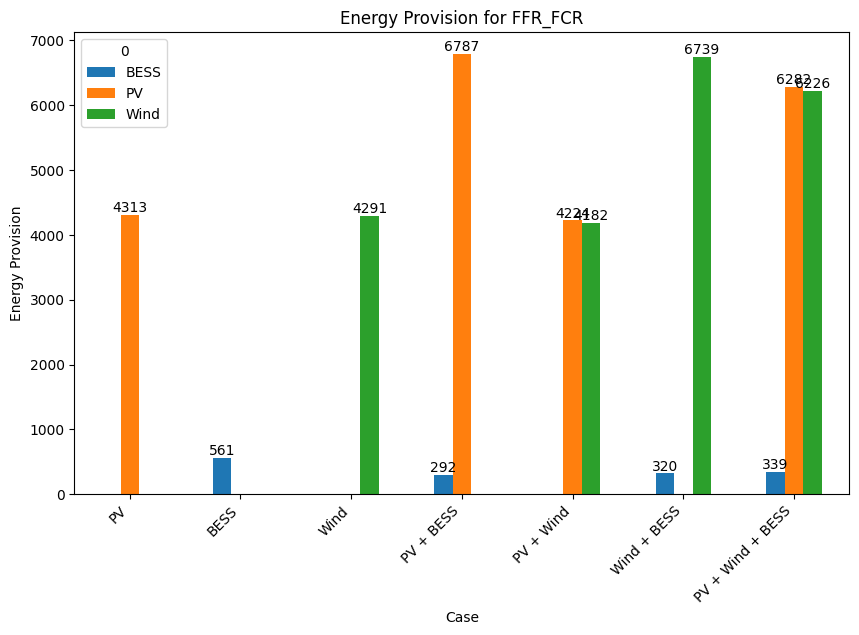

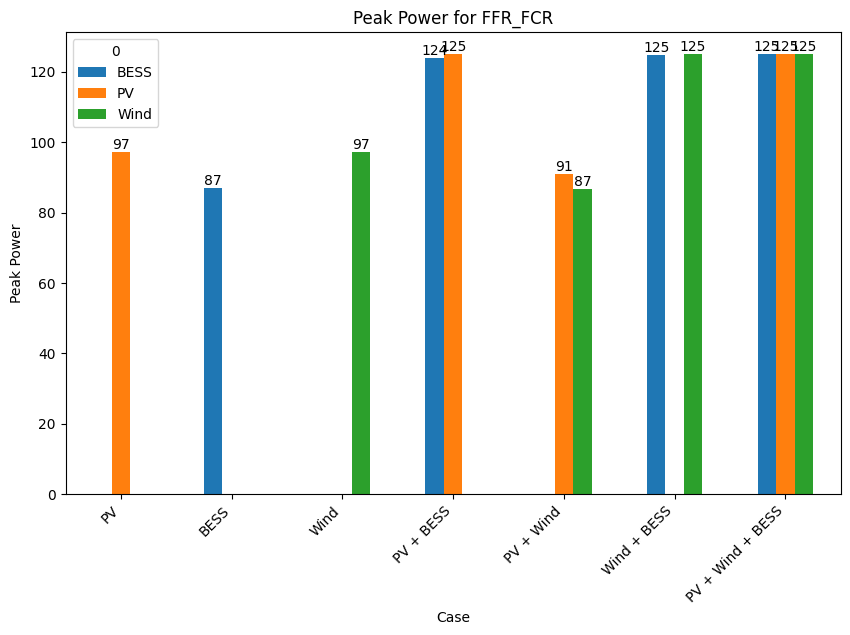

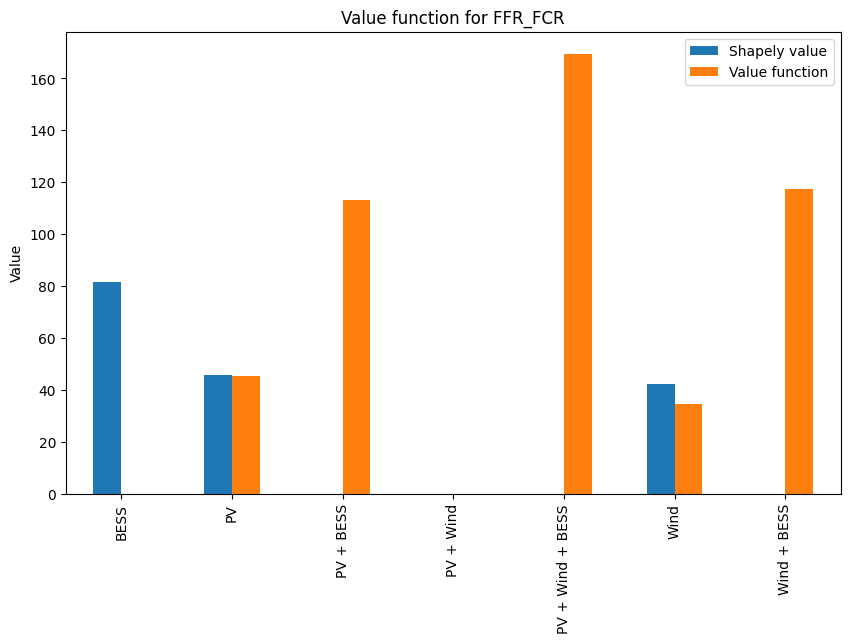

In [16]:
for service in services:
    df = pd.read_csv(f'{path}/{service}/energy_provision.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Energy Provision for {service}', ylabel='Energy Provision', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for peak power
    df = pd.read_csv(f'{path}/{service}/peak_power.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Peak Power for {service}', ylabel='Peak Power', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for reward and shapely values values
    df = pd.read_csv(f'{path}/{service}/value_function.csv', index_col=0)
    df = df.groupby(df.index).first()
    df = df.transpose()

    df_2 = pd.read_csv(f'{path}/{service}/shapely_value.csv', index_col=0)
    df_2 = df_2.groupby(df_2.index).first()
    df_2 = df_2.transpose()
    # merge df_2 into df where index match
    df = pd.merge(df, df_2, left_index=True, right_index=True, how='outer')
    df.columns = ['Value function', 'Shapely value']
    df.sort_index(axis=1, inplace=True)
    # change lables
    df.plot(kind='bar', figsize=(10, 6),
            title=f'Value function for {service}', ylabel='Value')

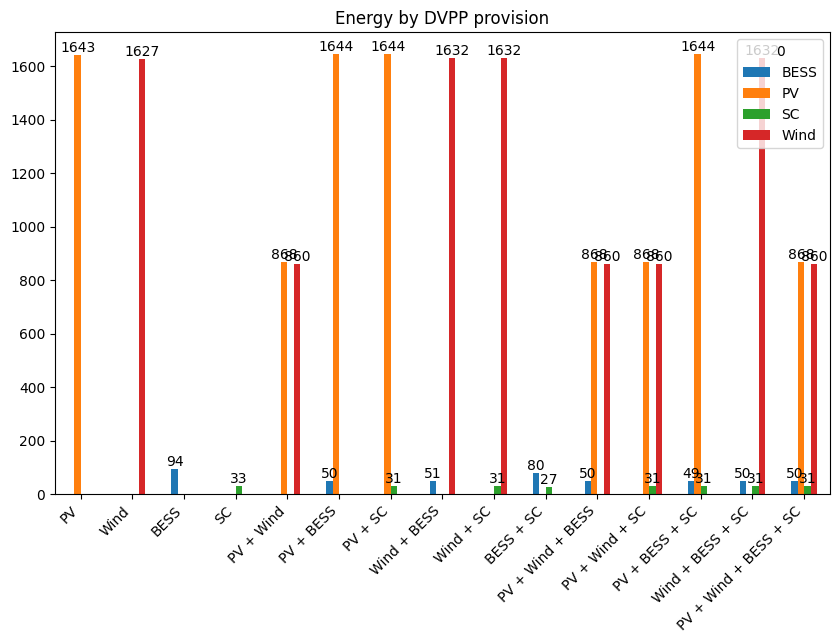

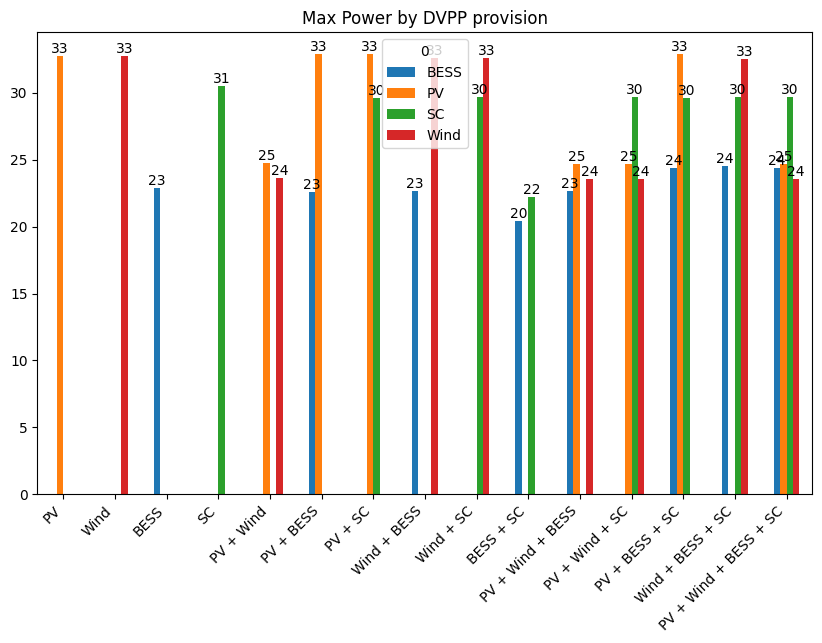

In [6]:
# same for max power provision
df = pd.read_csv('data/peak_power.csv', index_col=0)
df = df[~df.index.str.contains('\+')]
df.index = df.index.str.extract('([A-Za-z]+)')[0]
df = df.groupby(df.index).first()
df = df.transpose()
df.fillna(0)

# make grouped bar chart for each column
ax = df.plot(kind='bar', figsize=(10, 6),
             title='Max Power by DVPP provision')
plt.xticks(rotation=45, ha='right')
# show numbers above bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')
plt.show()

In [67]:
import math as mt
import itertools

In [108]:
VS = {'PV': 0, 'Wind': 0, 'BESS': 0, 'SC': 0, 'PV + Wind': 0, 'PV + BESS': 1, 'PV + SC': 1, 'Wind + BESS': 1, 'Wind + SC': 0, 'BESS + SC': 0, 'PV + Wind + BESS': 1, 'PV + Wind + SC': 1.2, 'PV + BESS + SC': 1.2, 'Wind + BESS + SC': 1.2, 'PV + Wind + BESS + SC': 1.6}
VS[()] = 0  # empty coalition

In [109]:
# convert strings to tuples removing spaces and split by +
VS = {tuple(k.replace(' ', '').split('+')): v for k, v in VS.items() if type(k) is str}
VS

{('PV',): 0,
 ('Wind',): 0,
 ('BESS',): 0,
 ('SC',): 0,
 ('PV', 'Wind'): 0,
 ('PV', 'BESS'): 1,
 ('PV', 'SC'): 1,
 ('Wind', 'BESS'): 1,
 ('Wind', 'SC'): 0,
 ('BESS', 'SC'): 0,
 ('PV', 'Wind', 'BESS'): 1,
 ('PV', 'Wind', 'SC'): 1.2,
 ('PV', 'BESS', 'SC'): 1.2,
 ('Wind', 'BESS', 'SC'): 1.2,
 ('PV', 'Wind', 'BESS', 'SC'): 1.6}

In [110]:
VS[()] = 0  # ensure empty coalition is present 

In [111]:
VS

{('PV',): 0,
 ('Wind',): 0,
 ('BESS',): 0,
 ('SC',): 0,
 ('PV', 'Wind'): 0,
 ('PV', 'BESS'): 1,
 ('PV', 'SC'): 1,
 ('Wind', 'BESS'): 1,
 ('Wind', 'SC'): 0,
 ('BESS', 'SC'): 0,
 ('PV', 'Wind', 'BESS'): 1,
 ('PV', 'Wind', 'SC'): 1.2,
 ('PV', 'BESS', 'SC'): 1.2,
 ('Wind', 'BESS', 'SC'): 1.2,
 ('PV', 'Wind', 'BESS', 'SC'): 1.6,
 (): 0}

In [112]:
my_names = ['PV', 'Wind', 'BESS', 'SC']

In [ ]:
def get_shapely_value(v: dict, players: list) -> dict:
    """
    Shapley value calculation for a coalition game.

    v: Characteristic function of the game, must be defined for EVERY coalition
        {tuple -> float}
    players: list of players
    """
    # initialize with zero value
    shapley_values = {p: 0 for p in players}  
    n = len(players)
    # iterate over all coalitions
    for c_size in range(1, len(players) + 1):  # iterate over coalition sizes
        for subset in itertools.combinations(players, c_size):  # get all coalitions of size c_size
            k = len(subset)
            for p in subset:  # iterate over player in coalition and change their shapely value
                subset_wo_p = tuple(c for c in subset if c != p)
                if subset_wo_p not in v:
                    print(f"Warning: Coalition {subset_wo_p} not in characteristic function. Assuming value 0.")
                marginal_contribution = v.get(subset) - v.get(subset_wo_p, 0)
                shapley_values[p] += marginal_contribution * mt.factorial(k - 1) * mt.factorial(n - k) / mt.factorial(n)

    return shapley_values

In [114]:
get_shapely_value(VS, my_names)

('PV',)
('Wind',)
('BESS',)
('SC',)
('PV', 'Wind')
('PV', 'BESS')
('PV', 'SC')
('Wind', 'BESS')
('Wind', 'SC')
('BESS', 'SC')
('PV', 'Wind', 'BESS')
('PV', 'Wind', 'SC')
('PV', 'BESS', 'SC')
('Wind', 'BESS', 'SC')
('PV', 'Wind', 'BESS', 'SC')


{'PV': 0.4666666666666667,
 'Wind': 0.30000000000000004,
 'BESS': 0.4666666666666667,
 'SC': 0.3666666666666667}